In [1]:
# Download 3k PBMCs data from a Healthy Donor
## Peripheral blood mononuclear cells (PBMCs) dataset is made publicly available by 10X Genomics
!mkdir -p data
!curl https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7443k  100 7443k    0     0  8109k      0 --:--:-- --:--:-- --:--:-- 8161k


In [1]:
# Import packages
import pandas as pd
import scanpy as sc

In [2]:
# Load gene expression matrix
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
# results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

# Makes the index unique by appending a number string to each duplicate index element
adata.var_names_make_unique()

# Print data shape
## 2,700 single-cells x 32,738 genes
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [3]:
# Basic cell and gene filtering to remove poor-quality cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/Users/jinhee/Documents/work/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


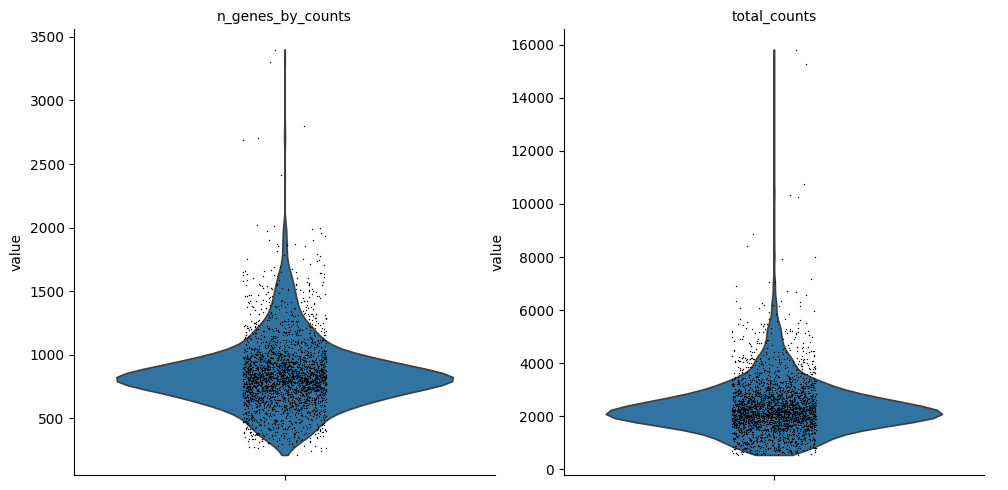

In [4]:
# Calculate quality control metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
# Check quality measures
## n_genes_by_counts: the number of genes with at least 1 count in a cell
## total_counts: Sum of counts for a gene
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], multi_panel=True)

In [5]:
# Keep raw counts for scVI
adata.layers['counts'] = adata.X.copy()

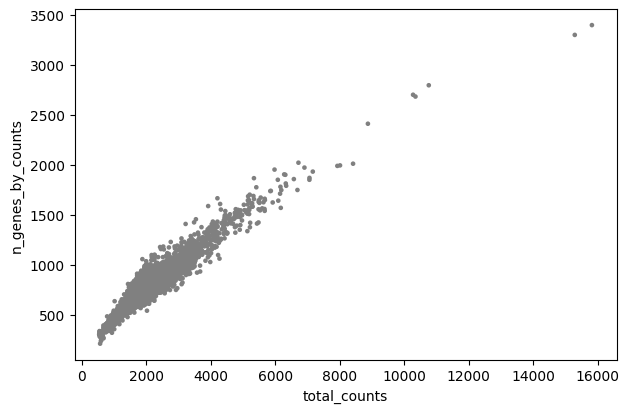

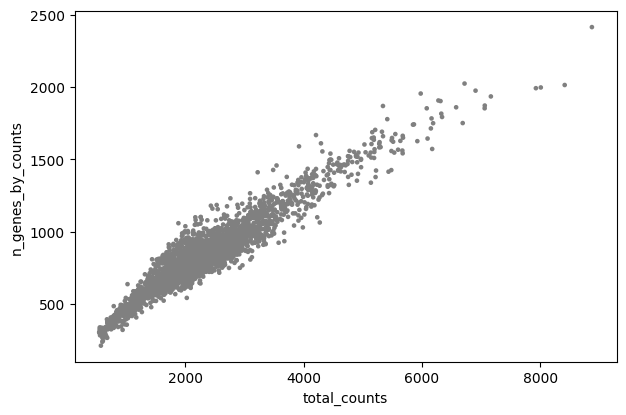

In [6]:
# Remove cells that have too many total counts (remove outliers)
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

# Validate again
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [7]:
# Normalize the data (library-size correction)
sc.pp.normalize_total(adata, target_sum=1e4)

# And log-transforms the data
sc.pp.log1p(adata)

/Users/jinhee/Documents/work/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
# Identify highly-variable genes for feature selection
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep raw data as adata.raw
adata.raw = adata.copy()

# Extract highly-variable genes for further analysis
adata = adata[:, adata.var.highly_variable]
adata # 2,695 cells x 1,863 genes

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


View of AnnData object with n_obs × n_vars = 2695 × 1863
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [9]:
# Scale the data
## Standard pre-processing step prior to dimensional reduction techniques
## Shift gene expression into zero mean and unit variance, and clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value=10)

/Users/jinhee/Documents/work/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Dimensionality reduction

In [10]:
# Perform dimensionality reduction by running principal component analysis (PCA)
## This reveals the main axes of variation and denoises the data
sc.tl.pca(adata, svd_solver="arpack")

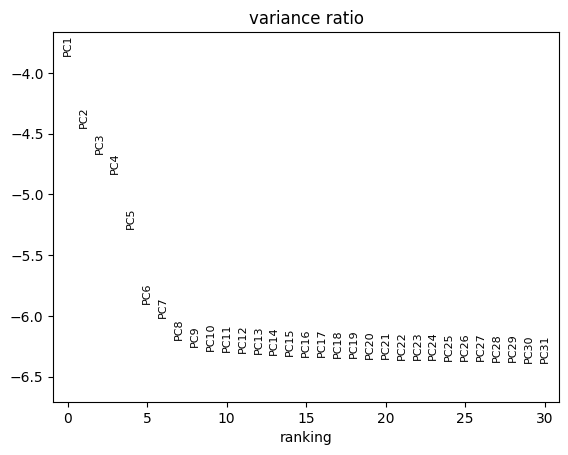

In [11]:
# Determine the dimensionality of this dataset
## How many PCs we should ocnsider to compute the neighborhood relations of cells used in the clustering function
sc.pl.pca_variance_ratio(adata, log=True)

In [12]:
# Compute the neighborhood graph of cells using PCA representation
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

/Users/jinhee/Documents/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


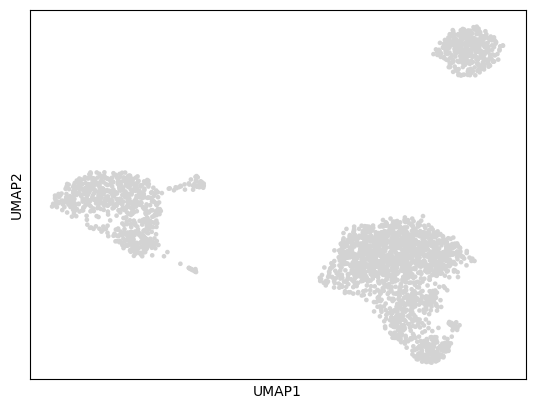

In [13]:
# Embedding the graph in two dimensions using UMAP
sc.tl.umap(adata)
# Visualize UMAP
sc.pl.umap(adata)

## Clustering

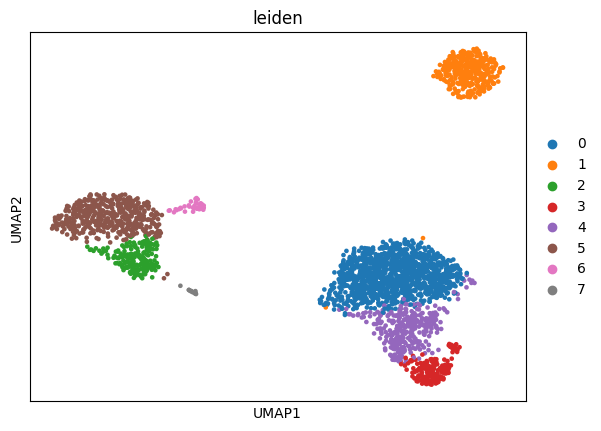

In [14]:
# Famous graph-based clustering method: Leiden algorithm (community detection based on optimizing modularity)
## Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section
sc.tl.leiden(adata, resolution=0.65, random_state=0, flavor='igraph', n_iterations=2, directed=False)

# Plot clustering results
## Obtained 9 clusters
sc.pl.umap(adata, color='leiden')

## Finding marker genes

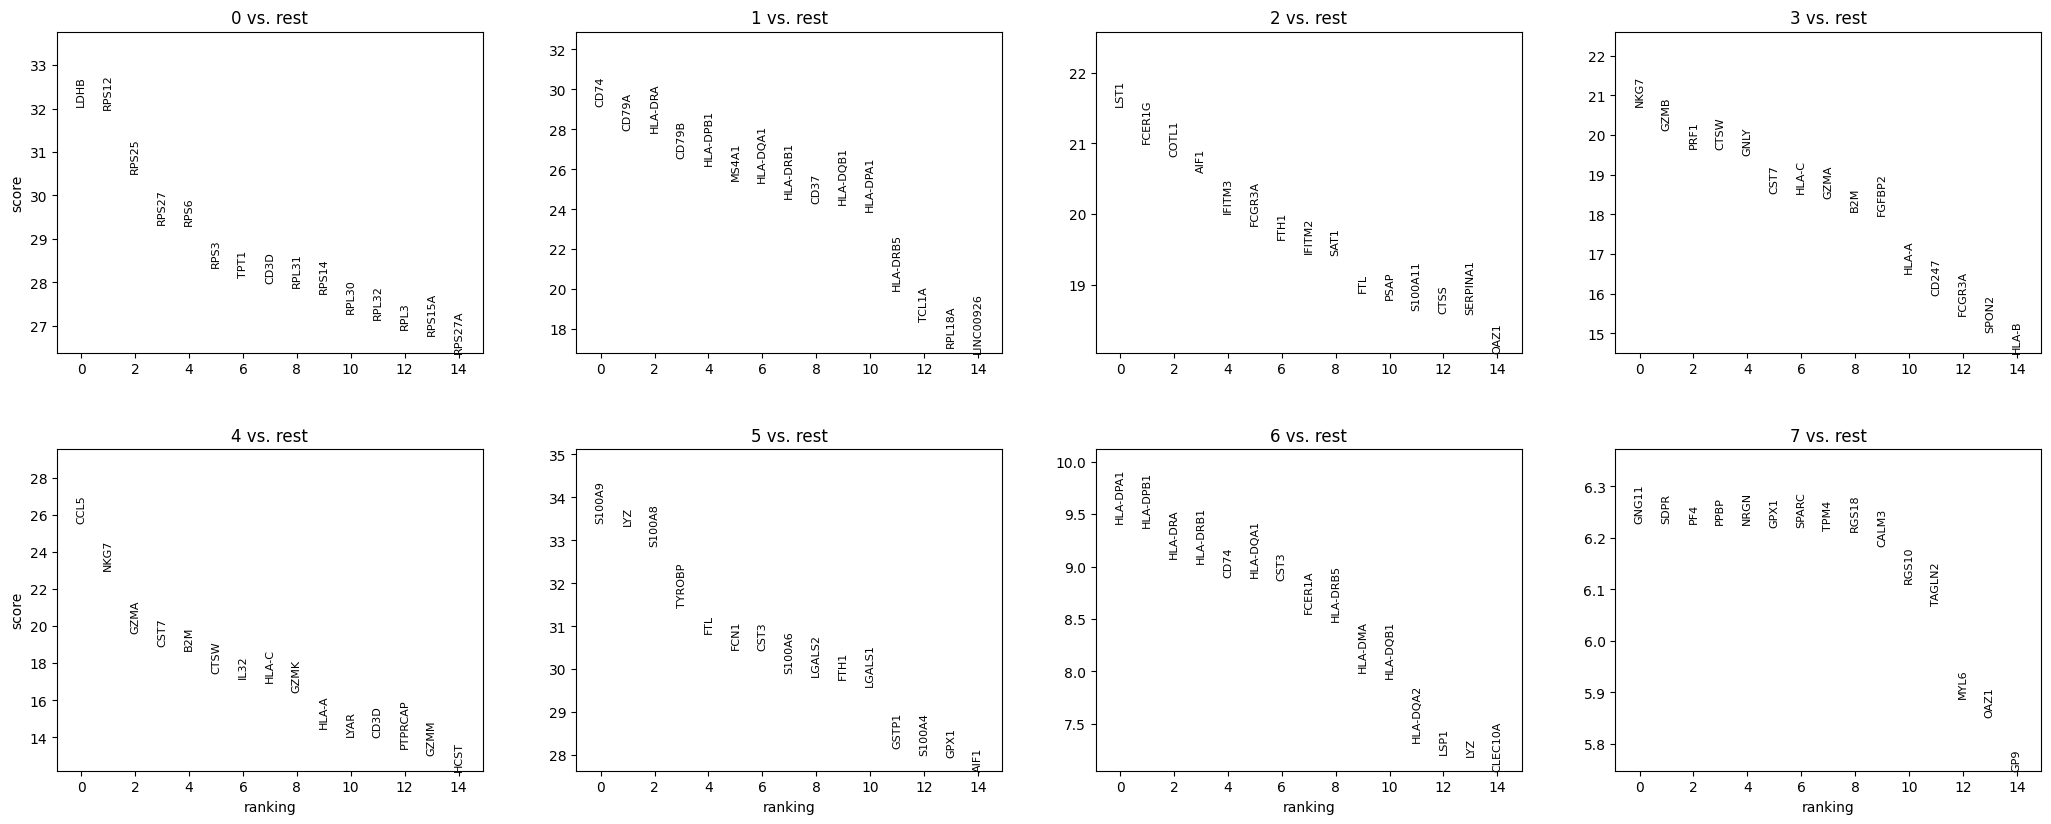

In [15]:
# Compute a ranking for the highly-differential genes in each cluster = Find cluster biomarkers
## Method-wilcoxon: identifies differentially expressed genes between two gorups of cells using a Wilcoxon Rank Sum test
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")

## Visualize top10 biomarkers in each cluster
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False) 

In [16]:
# Load ranked gene names and pvalues per cluster
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names

In [17]:
## cluster0 - CD4 T cells : CD3, 
## cluster1 - B cells: CD79A, MS4A1
## cluster2 - FCCR3A + Monocytes: FCGR3A, MS4A7
## cluster3 - NK cells: GNLY, NKG7
## cluster4 - CD8 T cells: CD8A, CD8B
## cluster5 - CD14+ Monocytes: CD14, LYZ, S100A8
## cluster6 - Dendritic: FCER1A, CST3
## cluster7 - Megakaryocytes: PPBP
new_cluster_names = ["CD4 T", "B", "FCGR3A+ Monocytes", "NK", "CD8 T", "CD14+ Monocytes", "Dendritic", "Megakaryocytes",]
# Add manually annotated cell types
adata.obs['leiden_manual'] = adata.obs['leiden']
adata.rename_categories("leiden_manual", new_cluster_names)

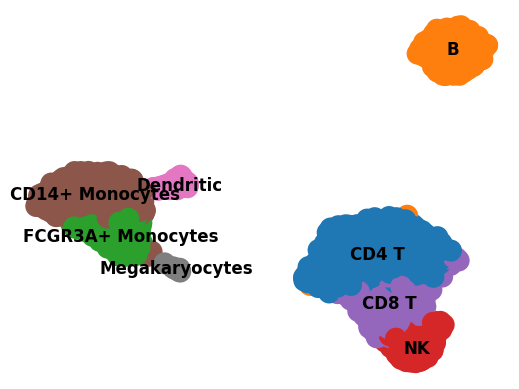

In [33]:
# Cell-type annotation
sc.pl.umap(adata, color="leiden_manual", legend_loc="on data", title="", size=1000,  legend_fontsize=12, frameon=False)

In [19]:
# Cell-type annotation using scType
import urllib.request
# Fetch scType script from the URL
url = "https://raw.githubusercontent.com/kris-nader/sc-type-py/main/sctype_py.py"
response = urllib.request.urlopen(url)
script = response.read().decode()
# Execute the script
exec(script)

In [20]:
# Extract scaled_matrix 
scaled_data = pd.DataFrame(adata.X)
scaled_data.columns =adata.var_names
scaled_data.index = adata.obs_names
scaled_data=scaled_data.T # Python-based method: (cells, genes), R-based method: (genes, cells)

In [22]:
# Run scType 
gs_list=gene_sets_prepare(path_to_db_file="ScTypeDB_full.xlsx",cell_type="PBMCs")
es_max = sctype_score(scRNAseqData = scaled_data, scaled = True, gs = gs_list['gs_positive'], gs2 = gs_list['gs_negative'])

<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encount

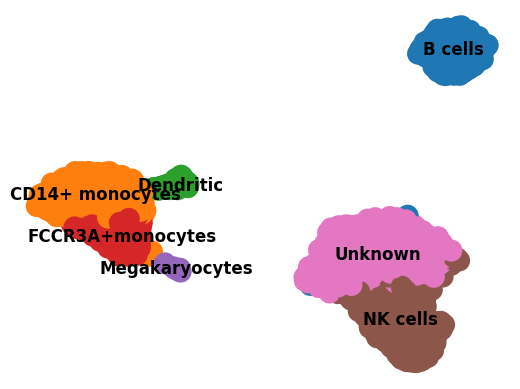

In [34]:
unique_clusters = adata.obs['leiden'].unique()
# Apply the function to each unique cluster and combine the results into a DataFrame
cL_results = pd.concat([process_cluster(cluster,adata,es_max,'leiden') for cluster in unique_clusters])

# Group by cluster and select the top row based on scores
sctype_scores = cL_results.groupby('cluster').apply(lambda x: x.nlargest(1, 'scores')).reset_index(drop=True)

# Set low-confidence clusters to "Unknown"
sctype_scores.loc[sctype_scores['scores'] < sctype_scores['ncells'] / 4, 'type'] = 'Unknown'

# Iterate over unique clusters
adata.obs['leiden_sctype'] = ""
for cluster in sctype_scores['cluster'].unique():
    # Filter sctype_scores for the current cluster
    cl_type = sctype_scores[sctype_scores['cluster'] == cluster]
    # Get the type for the current cluster
    cl_type_value = cl_type['type'].iloc[0]
    # Update 'sctype_classification' in pbmc.obs for cells belonging to the current cluster
    adata.obs.loc[adata.obs['leiden'] == cluster, 'leiden_sctype'] = cl_type_value

# Plot the UMAP with sctype_classification as labels
#sc.pl.umap(adata, color='leiden_sctype', legend_loc="on data", title='UMAP with sctype_classification', frameon=False)
sc.pl.umap(adata, color="leiden_sctype", legend_loc="on data", title="", size=1000,  legend_fontsize=12, frameon=False)

# scVI-based results

In [24]:
import scvi

In [25]:
# Set-up the scVI model
scvi.model.SCVI.setup_anndata(adata, layer="counts")

/Users/jinhee/Documents/work/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [26]:
# Creating and training a model
model = scvi.model.SCVI(adata)
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jinhee/Documents/work/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████████████████████████████████████| 400/400 [02:19<00:00,  2.70it/s, v_num=1, train_loss_step=489, train_loss_epoch=471]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████████████████████████████| 400/400 [02:19<00:00,  2.86it/s, v_num=1, train_loss_step=489, train_loss_epoch=471]


In [27]:
# Obtain model output (latent vectors)
latent = model.get_latent_representation()
adata.obsm['X_scVI'] = latent
print (latent.shape)

(2695, 10)


In [28]:
# Store normalized values
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size=10e4)

/var/folders/1c/6hmfv23j2wl7xmh5460lr_000000gn/T/ipykernel_8866/2198482262.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added='leiden_scvi', resolution=0.8)


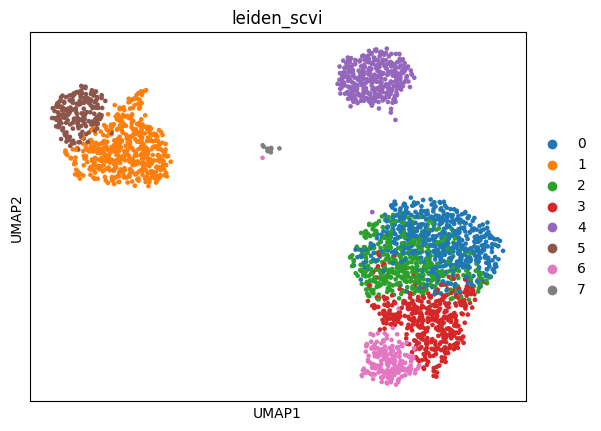

In [29]:
# UMAP with scVI-imputed matrix
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep='X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='leiden_scvi', resolution=0.8)
sc.pl.umap(adata, color='leiden_scvi')

In [30]:
# scType-based annotation
## Extract scaled_matrix 
scaled_data = pd.DataFrame(adata.layers['scvi_normalized'])
scaled_data.columns =adata.var_names
scaled_data.index = adata.obs_names
scaled_data=scaled_data.T # Python-based method: (cells, genes), R-based method: (genes, cells)

In [31]:
# Run scType 
#gs_list=gene_sets_prepare(path_to_db_file="/Users/sungjae/Documents/work/code/ScTypeDB_full.xlsx",cell_type="PBMCs")
es_max = sctype_score(scRNAseqData = scaled_data, scaled = True, gs = gs_list['gs_positive'], gs2 = gs_list['gs_negative'])

<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encountered in scalar divide
<string>:190: RuntimeWarning: invalid value encount

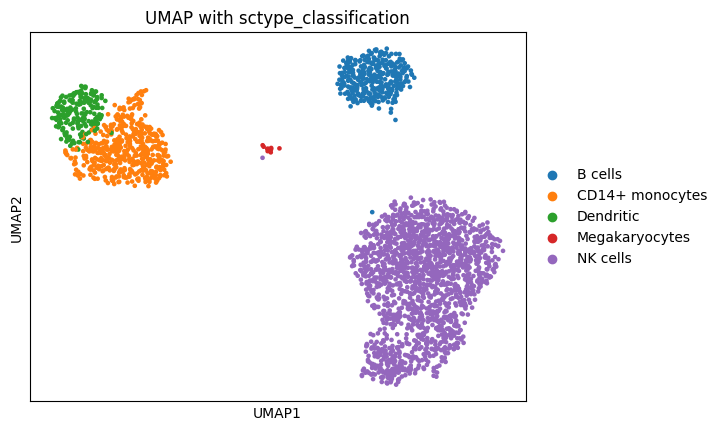

In [32]:
unique_clusters = adata.obs['leiden_scvi'].unique()
# Apply the function to each unique cluster and combine the results into a DataFrame
cL_results = pd.concat([process_cluster(cluster,adata,es_max,'leiden_scvi') for cluster in unique_clusters])

# Group by cluster and select the top row based on scores
sctype_scores = cL_results.groupby('cluster').apply(lambda x: x.nlargest(1, 'scores')).reset_index(drop=True)

# Set low-confidence clusters to "Unknown"
sctype_scores.loc[sctype_scores['scores'] < sctype_scores['ncells'] / 4, 'type'] = 'Unknown'

# Iterate over unique clusters
adata.obs['leiden_scvi_sctype'] = ""
for cluster in sctype_scores['cluster'].unique():
    # Filter sctype_scores for the current cluster
    cl_type = sctype_scores[sctype_scores['cluster'] == cluster]
    # Get the type for the current cluster
    cl_type_value = cl_type['type'].iloc[0]
    # Update 'sctype_classification' in pbmc.obs for cells belonging to the current cluster
    adata.obs.loc[adata.obs['leiden_scvi'] == cluster, 'leiden_scvi_sctype'] = cl_type_value

# Plot the UMAP with sctype_classification as labels
sc.pl.umap(adata, color='leiden_scvi_sctype', title='UMAP with sctype_classification')

# Visualization

In [33]:
# Obtain marker gene list from scType database
marker_genes = np.concatenate([gs_list['gs_positive'][i] for i in gs_list['gs_positive']])

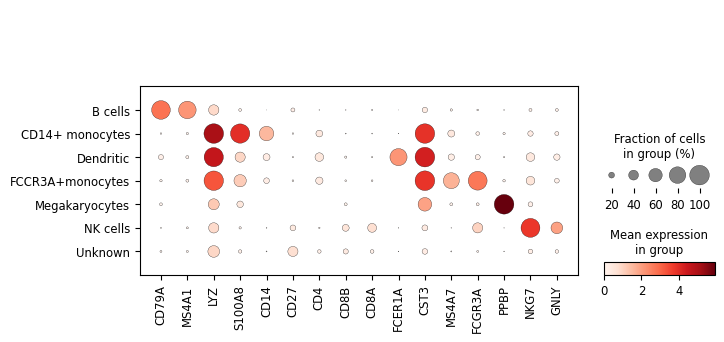

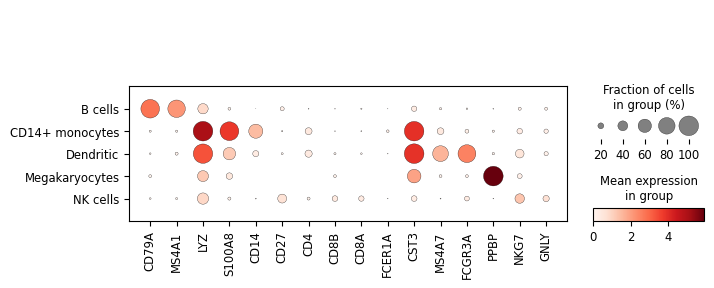

In [34]:
# Dotplot
sc.pl.dotplot(adata, marker_genes, groupby="leiden_sctype"); # graph-based
sc.pl.dotplot(adata, marker_genes, groupby="leiden_scvi_sctype"); # machine learning-based

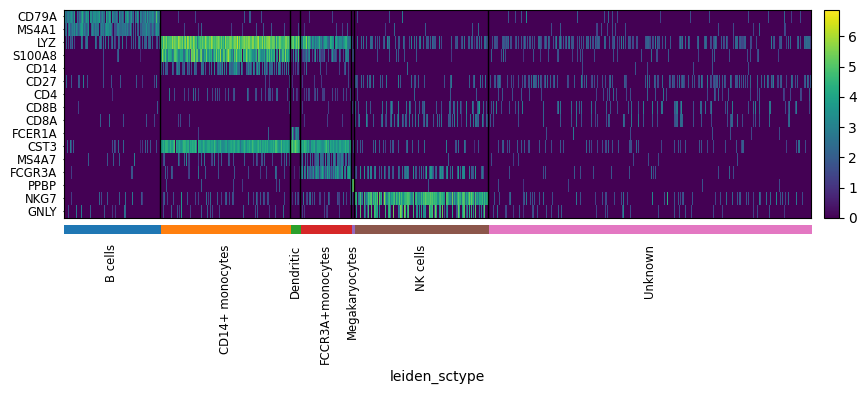

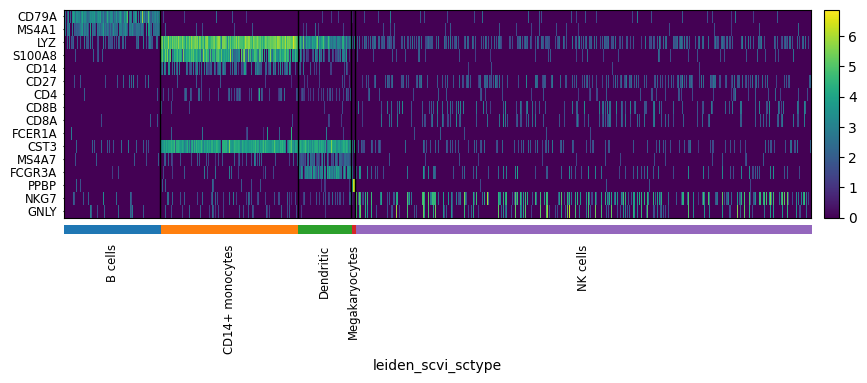

In [35]:
# Heatmaps
sc.pl.heatmap(adata, marker_genes, groupby='leiden_sctype', cmap='viridis', swap_axes=True) # graph-based
sc.pl.heatmap(adata, marker_genes, groupby='leiden_scvi_sctype', cmap='viridis', swap_axes=True) # machine learning-based